# Calculate and Compile Seasonal NINO34/AMO/PDO Indices from the PHYDA Ensemble

### Start Clean

In [2]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors
import statsmodels.api as sm
import statsmodels

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Load All Instrumental Climate Indices and Calcualte Seasonal Averages

In [4]:
# NINO 3.4 (ENSO)----------------------------------------------------------------------------------------------------------

# Load into dataframes
# https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/
df_nino34   = pd.read_csv('../data/obsindices/nino34.txt',delim_whitespace=True, header=None)
yr_nino34   = np.array(df_nino34.iloc[:,0])
data_nino34 = np.array(df_nino34.iloc[:,1:])

# AMO Index, from hadiSST--------------------------------------------------------------------------------------------------
# https://climexp.knmi.nl/getindices.cgi?WMO=UKMOData/amo_hadsst&STATION=AMO_hadsst&TYPE=i&id=someone@somewhere
# # version :: HadSST.4.0.1.0
# Load into dataframes
df_amo   = pd.read_csv('../data/obsindices/amo_hadsst4.csv',delim_whitespace=True, header=None)
yr_amo   = np.array(df_amo.iloc[:,0])
data_amo = np.array(df_amo.iloc[:,1:])

# Pacific Decadal Oscillation Index------------------------------------------------------------------------------------------
# https://www.ncei.noaa.gov/access/monitoring/pdo/
# Load into dataframes
df_pdo   = pd.read_csv('../data/obsindices/pdo_ncei.txt',delim_whitespace=True, header=None)
yr_pdo   = np.array(df_pdo.iloc[:,0])
data_pdo = np.array(df_pdo.iloc[:,1:])

# Replace missing values with NaN
data_nino34[data_nino34<=-90]=np.nan
data_amo[data_amo<=-90]=np.nan
data_pdo[data_pdo>=90]=np.nan

# Seasonal Averages---------------------------------------------------------------------------------------------------------

# Common Period (anchored to January)
yrs_seas = np.arange(1871,2023+1)

# Arrays containing all seasonal information: name, months, indices
all_seas_txt  = np.array(['SON','DJF','MAM','JJA'])
all_seas_mons = np.array([[9,10,11],[12,1,2],[3,4,5],[6,7,8]])
all_seas_inds = np.array([[-1,-1,-1],[-1,0,0],[0,0,0],[0,0,0]])

# Storage Arrays
seas_nino34 = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan
seas_amo    = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan
seas_pdo    = np.zeros((all_seas_txt.size,3,yrs_seas.size))*np.nan

# Seasonal loop
for n_seas in enumerate(all_seas_txt):
    # Current seasonal information
    seas_txt  = copy.deepcopy(n_seas[1])
    seas_mons = all_seas_mons[n_seas[0]].copy()
    ind_yr     = all_seas_inds[n_seas[0]].copy()
    
    print('------------------')
    print(seas_txt)
    print(seas_mons)
    print(ind_yr)
    print('------------------')
    
    # Loop through each year and month
    for n_yr in enumerate(yrs_seas):
        for n_mon in enumerate(seas_mons):
            # Current stuff
            curr_yr  = n_yr[1]+ind_yr[n_mon[0]]
            curr_mon = n_mon[1]
            print('      ',curr_yr,curr_mon)

            # Month loc index
            i_mon = np.where(mons==curr_mon)[0]
        
            # Find year location, accounting for lag across calendar years
            i_yr_nino34 = np.where( (yr_nino34==curr_yr) )[0]
            i_yr_amo    = np.where( (yr_amo==curr_yr) )[0]
            i_yr_pdo    = np.where( (yr_pdo==curr_yr) )[0]

            # Store current values
            seas_nino34[n_seas[0],n_mon[0],n_yr[0]]   = data_nino34[i_yr_nino34,i_mon].copy()
            seas_amo[n_seas[0],n_mon[0],n_yr[0]]      = data_amo[i_yr_amo,i_mon].copy()
            seas_pdo[n_seas[0],n_mon[0],n_yr[0]]      = data_pdo[i_yr_pdo,i_mon].copy()

# Create seasonal averages/sums
seas_ave_nino34 = np.mean(seas_nino34,axis=1)
seas_ave_amo    = np.mean(seas_amo,axis=1)
seas_ave_pdo    = np.mean(seas_pdo,axis=1)

# Recenter Everything to zero mean
mean_nino34 = np.nanmean(seas_ave_nino34,axis=1); seas_ave_nino34 = seas_ave_nino34-np.expand_dims(mean_nino34,axis=1)
mean_amo    = np.nanmean(seas_ave_amo,axis=1);    seas_ave_amo    = seas_ave_amo-np.expand_dims(mean_amo,axis=1)
mean_pdo    = np.nanmean(seas_ave_pdo,axis=1);    seas_ave_pdo    = seas_ave_pdo-np.expand_dims(mean_pdo,axis=1)


------------------
SON
[ 9 10 11]
[-1 -1 -1]
------------------
       1870 9
       1870 10
       1870 11
       1871 9
       1871 10
       1871 11
       1872 9
       1872 10
       1872 11
       1873 9
       1873 10
       1873 11
       1874 9
       1874 10
       1874 11
       1875 9
       1875 10
       1875 11
       1876 9
       1876 10
       1876 11
       1877 9
       1877 10
       1877 11
       1878 9
       1878 10
       1878 11
       1879 9
       1879 10
       1879 11
       1880 9
       1880 10
       1880 11
       1881 9
       1881 10
       1881 11
       1882 9
       1882 10
       1882 11
       1883 9
       1883 10
       1883 11
       1884 9
       1884 10
       1884 11
       1885 9
       1885 10
       1885 11
       1886 9
       1886 10
       1886 11
       1887 9
       1887 10
       1887 11
       1888 9
       1888 10
       1888 11
       1889 9
       1889 10
       1889 11
       1890 9
       1890 10
       1890 11
       1891 

/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_79206/787223334.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nino34   = pd.read_csv('../data/obsindices/nino34.txt',delim_whitespace=True, header=None)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_79206/787223334.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_amo   = pd.read_csv('../data/obsindices/amo_hadsst4.csv',delim_whitespace=True, header=None)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_79206/787223334.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_pdo   = pd.read_csv('../data/obsindices/pdo_ncei.txt',delim_whitespace=True, header=None)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh

## Create land-sea and cosing Area Weighting Mask from PHYDA PDSI

loading PDSI Data for LSMASK


Text(0.5, 1.0, 'PHYDA v2: Regional Area Weighting Grid')

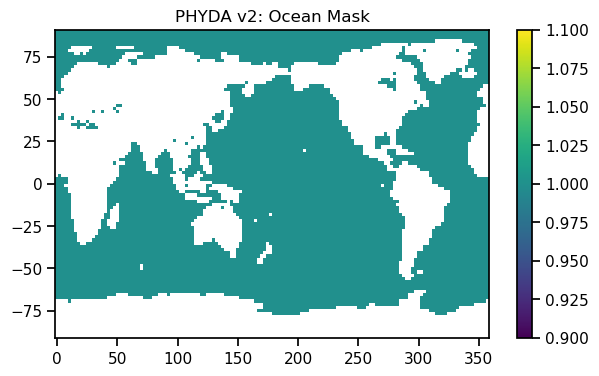

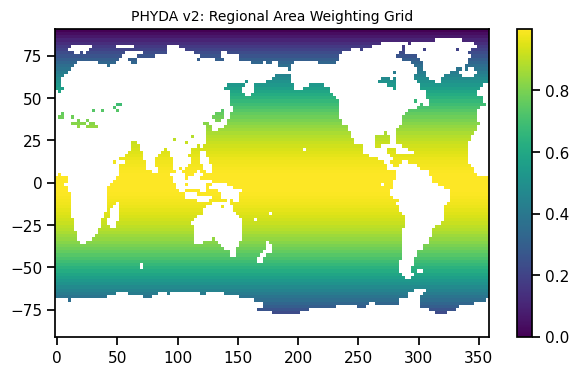

In [6]:
# Open Data File
print('loading PDSI Data for LSMASK')
nc_file  = netCDF4.Dataset('../../../../GEODATA/PHYDA/v2/phyda_ens_pdsi_JunAug_r.1-2000_d.21-Nov-2018.nc')

# Load time, lat, lon data
lat_phy  = nc_file.variables['lat'][:]
lon_phy  = nc_file.variables['lon'][:]
yr_phy   = nc_file.variables['time'][:]

# Load PHYDA PDSI
pdsi_phy = nc_file.variables['pdsi_ens'][0,0,:,:]

# Close file
nc_file.close()

# Create Land Sea Mask
pdsi_phy=np.array(pdsi_phy.data)
oceancells = np.where(np.isnan(pdsi_phy)==1)
landcells  = np.where(np.isnan(pdsi_phy)==0)
lsmask = pdsi_phy.copy()
lsmask[landcells]=np.nan
lsmask[oceancells]=1.0

# COSINE AREA WEIGHTING MASK
# Create Latitude Weights: WRU
lat_wts               = np.cos(np.deg2rad(lat_phy))
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_phy)
lat_wts_grid_ocean    = np.swapaxes(lat_wts_grid,1,0)*lsmask

plt.figure(figsize=(7,4))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})
plt.pcolormesh(lon_phy,lat_phy,lsmask)
plt.colorbar()
plt.title('PHYDA v2: Ocean Mask')

plt.figure(figsize=(7,4))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})
plt.pcolormesh(lon_phy,lat_phy,lat_wts_grid_ocean)
plt.colorbar()
plt.title('PHYDA v2: Regional Area Weighting Grid',{'fontsize':10})



## Load PHYDA Ensemble Nino 3.4 and AMO Indices and GMT

In [7]:
# Load NINO 3.4 and AMO Indices
fname_phyda   = '../../../../GEODATA/PHYDA/v2/phyda_ens_indexvars_JunAug_r.1-2000_d.21-Nov-2018.nc'
phyda_nc      = netCDF4.Dataset(fname_phyda,"r",format="NETCDF4")
amo_phyJJA    = phyda_nc.variables['amo_ens'][:] # get values
gmt_phyJJA    = phyda_nc.variables['gmt_ens'][:] # get values
nino34_mon    = phyda_nc.variables['Nino_3.4_ens'][:] # get values
yr_phyda      = np.arange(1,2000+1)
phyda_nc.close()

# Reshape monthly NINO 3.4 arrays to years x month-
nino34_phyda_mon = np.reshape(nino34_mon,(100,2000,12))

# NINO 3.4 Seasonal Processing
# Years for ENSO Processing
yrs_enso_proc = yr_phyda[1:].copy()

# Year Indices for Months
iyr_dec = np.where(yr_phyda<=1999)[0]
iyr_jan = np.where(yr_phyda>=2)[0]
iyr_feb = np.where(yr_phyda>=2)[0]

# DJF Seasonal average for NINO 3.4
nino34_phyDJF = (nino34_phyda_mon[:,iyr_dec,11]+nino34_phyda_mon[:,iyr_jan,0]+nino34_phyda_mon[:,iyr_feb,1])/3

## Trim to 800-2000 CE
# year and PDO
i_trim        = np.where(yr_phyda>=800)[0]
yr_trim       = yr_phyda[i_trim].copy()
amo_phyJJA    = amo_phyJJA[:,i_trim].copy()
gmt_phyJJA    = gmt_phyJJA[:,i_trim].copy()
# ENSO
i_trim        = np.where(yrs_enso_proc>=800)[0]
nino34_phyDJF = nino34_phyDJF[:,i_trim].copy()
#
#plt.plot(np.mean(nino34_phyda_mon,axis=0))

## Define parameters for detrending (100-year lowess smooth), Scaling, & Save Seasonal Average Observed SST Indices

In [10]:
# Lowess window: using centennial filter to remove long term trends but retain multidecadal variability---------------------------------------------------------------
yrs_smooth = 100;

# Fractional smooth
frac_smooth = yrs_smooth/yr_trim.size

# Observation Time Series for Scaling/Comparison----------------------------------------------------------------------------------------------------------------------
# Time vector is yrs_seas, year anchored to January

obs_amoJJA  = seas_ave_amo[3,:].copy()
obs_ninoDJF = seas_ave_nino34[1,:].copy()
obs_pdoDJF  = seas_ave_pdo[1,:].copy()

# Baseline for scaling------------------------------------------------------------------------------------------------------------------------------------------------

# Baseline to scale over
yrs_base     = np.arange(1901,2000+1);
i_base_phyda = np.nonzero(np.in1d(yr_trim,yrs_base))[0]
i_base_obs   = np.nonzero(np.in1d(yrs_seas,yrs_base))[0]

# Save observed Indices---------------------------------------------------------------------------------------------------------------------------------------------

# Initialize and Create Dataframe
df_out_obs_sst = pd.DataFrame(columns=['Year','ninoDJF','pdoDJF','amoJJA'],index=None)
df_out_obs_sst['Year']    = yrs_seas
df_out_obs_sst['ninoDJF'] = obs_ninoDJF
df_out_obs_sst['pdoDJF']  = obs_pdoDJF
df_out_obs_sst['amoJJA']  = obs_amoJJA

# Save to csv file
df_out_obs_sst.to_csv('../data/obsindices/obs_sst_indices.csv',index=False)

# Column Names for saving output to csv files-----------------------------------------------------------------------------------------------------------------------

# Column Names
cols_txt = []
cols_txt.append('Year')    
for n_col in np.arange(1,101):
    col_str = 'ens'+str(n_col)
    cols_txt.append(col_str)    
    

## Save GMT Output

In [11]:
# Create Output Array
output_array = np.hstack(  (np.expand_dims(yr_trim,1),gmt_phyJJA.swapaxes(0,1)) )
    
# Initialize and Create Dataframe
df_out_phyda_pdsi = pd.DataFrame(columns=cols_txt,data=output_array,index=None)

# Save to csv file
df_out_phyda_pdsi.to_csv('../data/obsindices/ensphyda_gmtJJA.csv',index=False)
df_out_phyda_pdsi


,Year,ens1,ens2,ens3,ens4,ens5,ens6,ens7,ens8,ens9,...,ens91,ens92,ens93,ens94,ens95,ens96,ens97,ens98,ens99,ens100
0,800.0,16.521362,16.389186,16.578290,16.544566,16.487222,16.392204,16.560772,16.375030,16.326626,...,16.425825,16.550453,16.810660,16.422787,16.450380,16.348666,16.542236,16.409976,16.553420,16.660920
1,801.0,16.605284,16.475095,16.662721,16.629281,16.569395,16.484523,16.641487,16.456045,16.412071,...,16.511417,16.643199,16.899481,16.506428,16.539471,16.437902,16.626425,16.494122,16.637912,16.746476
2,802.0,16.651858,16.520125,16.709627,16.675724,16.619119,16.523586,16.691606,16.505659,16.457240,...,16.557080,16.681071,16.941480,16.554043,16.581706,16.479366,16.673386,16.539839,16.683564,16.791683
3,803.0,16.608398,16.476222,16.665326,16.631602,16.574258,16.479240,16.647808,16.462067,16.413662,...,16.512861,16.637489,16.897696,16.509823,16.537416,16.435702,16.629272,16.497012,16.640456,16.747956
4,804.0,16.667160,16.536584,16.724395,16.690943,16.630684,16.546264,16.703191,16.517825,16.474218,...,16.572080,16.704976,16.961281,16.567847,16.600594,16.499653,16.688069,16.556081,16.699841,16.808362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,1996.0,16.988058,16.887030,16.966409,17.040675,16.999501,16.907288,17.027114,16.871883,16.828690,...,16.921330,17.084863,17.063163,16.939464,16.999282,16.893789,17.042422,16.895932,17.038186,17.055137
1197,1997.0,17.070916,16.960250,17.034268,17.116410,17.074069,16.983551,17.093804,16.944660,16.898730,...,16.991731,17.155097,17.147927,17.012621,17.066238,16.965163,17.122676,16.969214,17.111271,17.130975
1198,1998.0,17.337233,17.222980,17.320811,17.386883,17.313293,17.255750,17.361442,17.213780,17.152538,...,17.263590,17.420330,17.422439,17.293014,17.319378,17.245499,17.383024,17.241874,17.357959,17.414868
1199,1999.0,16.987259,16.867233,16.961022,17.043218,16.958214,16.916583,17.001175,16.858078,16.791666,...,16.910893,17.073939,17.079573,16.936933,16.967701,16.889120,17.030739,16.895189,16.997992,17.066542


## AMO Processing from PHYDA (Detrending and Rescaling)

Obs. Mean:  -0.04846268120775439 ; Obs. StDv: 0.26394507682197293
PHYDA Mean:  [-0.04846268 -0.04846268 -0.04846268 -0.04846268 -0.04846268]
PHYDA StDv:  [0.26394508 0.26394508 0.26394508 0.26394508 0.26394508]


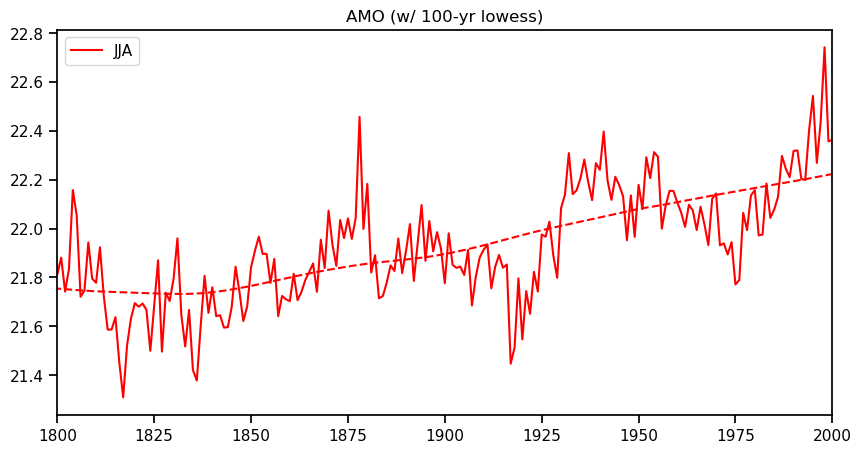

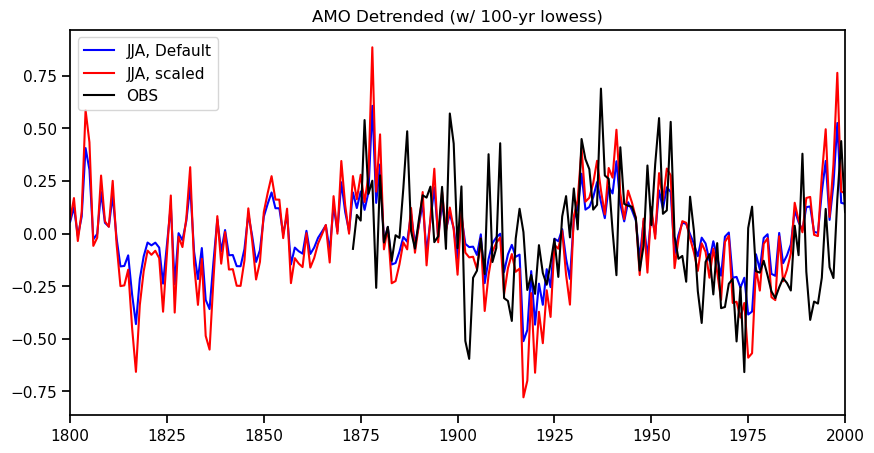

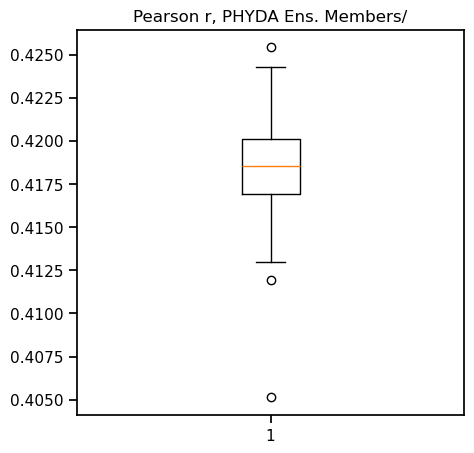

In [17]:
# Storage array of smoothed values
amo_jja_anom_lowess = np.zeros((100,yr_trim.size))*np.nan

# Lowess Smoothing of each ensemble member
for n_ens in np.arange(0,100):
    
    # Current ensemble member
    currens_amo = amo_phyJJA[n_ens,:].copy()
    
    # Calculate the lowess smooth
    amoJJA_smooth = statsmodels.nonparametric.smoothers_lowess.lowess(currens_amo,yr_trim,frac=frac_smooth)   # 30 year lowess
    
    # Remove lowess signal
    amo_jja_anom_lowess[n_ens,:] = currens_amo-amoJJA_smooth[:,1]

# Figures for spot-checking
plt.figure(figsize=(10,5))
plt.title('AMO (w/ '+str(yrs_smooth)+'-yr lowess)')
plt.plot(yr_trim,currens_amo,color='r',linestyle='-',label='JJA')
plt.plot(yr_trim,amoJJA_smooth[:,1],color='r',linestyle='--')
plt.legend(loc=0)
plt.xlim(1800,2000)    

# JJA AMO Detrended, including scaling to match observations----------------------------------------------------------------------------------------------

# Remove Mean and Standard Dev. of PHYDA
mean_amo_phyda              = np.expand_dims(np.mean(amo_jja_anom_lowess[:,i_base_phyda],axis=1),1)
stdv_amo_phyda              = np.expand_dims(np.std(amo_jja_anom_lowess[:,i_base_phyda],axis=1),1)
amo_jja_anom_lowess_rescale = (amo_jja_anom_lowess-mean_amo_phyda)/stdv_amo_phyda

# Apply Scaling from Observations
mean_obs_amo = np.mean(obs_amoJJA[i_base_obs])
stdv_obs_amo = np.std(obs_amoJJA[i_base_obs])
amo_jja_anom_lowess_rescale = (amo_jja_anom_lowess_rescale*stdv_obs_amo)+mean_obs_amo

# Figure for checking rescaling
n_ens = 10
plt.figure(figsize=(10,5))
plt.title('AMO Detrended (w/ '+str(yrs_smooth)+'-yr lowess)')
plt.plot(yr_trim,amo_jja_anom_lowess[n_ens,:],color='b',linestyle='-',label='JJA, Default')
plt.plot(yr_trim,amo_jja_anom_lowess_rescale[n_ens,:],color='r',linestyle='-',label='JJA, scaled')
plt.plot(yrs_seas,obs_amoJJA,color='k',linestyle='-',label='OBS')
plt.legend(loc=0)
plt.xlim(1800,2000)

# Check Scaling
print('Obs. Mean: ',mean_obs_amo,'; Obs. StDv:',stdv_obs_amo)
print('PHYDA Mean: ',np.mean(amo_jja_anom_lowess_rescale[20:25,i_base_phyda],axis=1))
print('PHYDA StDv: ',np.std(amo_jja_anom_lowess_rescale[20:25,i_base_phyda],axis=1))

# Calculate Correlations in Ensemble
correns_amo = np.zeros(100)*np.nan

# Ensemble loop for Correlation
for n_ens in np.arange(0,100):
    correns_amo[n_ens], pval = scipy.stats.pearsonr(obs_amoJJA[i_base_obs],amo_jja_anom_lowess_rescale[n_ens,i_base_phyda])

# Histogram of correlations
plt.figure(figsize=(5,5))
plt.boxplot(correns_amo)
plt.title('Pearson r, PHYDA Ens. Members/')

# Save Ensemble AMO------------------------------------------------------------------------------------------------------------------------------

# Create Output Array
output_array = np.hstack(  (np.expand_dims(yr_trim,1),amo_jja_anom_lowess_rescale.swapaxes(0,1)) )
    
# Initialize and Create Dataframe
df_out_phyda_pdsi = pd.DataFrame(columns=cols_txt,data=output_array,index=None)

# Save to csv file
df_out_phyda_pdsi.to_csv('../data/ensphyda/indices/ensphyda_amoJJA_scaled_detrend.csv',index=False)
#df_out_phyda_pdsi


## NINO3.4 Processing

Obs. Mean:  0.0638381263616558 ; Obs. StDv: 0.877449320473838
PHYDA Mean:  [0.06383813 0.06383813 0.06383813 0.06383813 0.06383813]
PHYDA StDv:  [0.87744932 0.87744932 0.87744932 0.87744932 0.87744932]


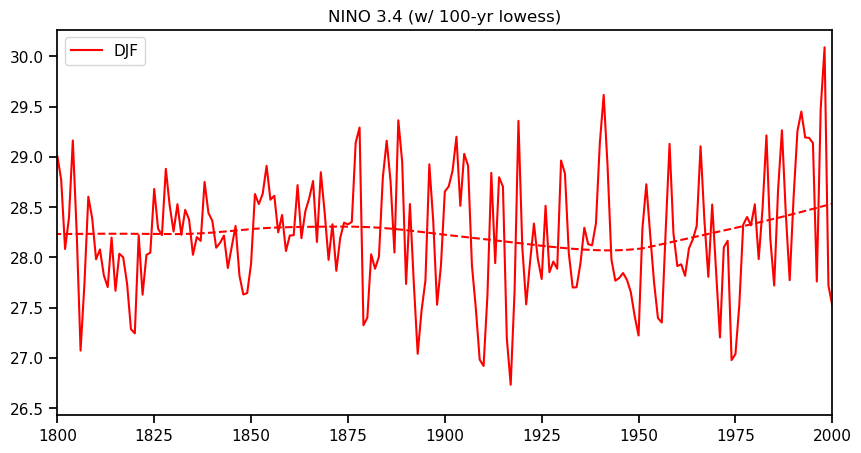

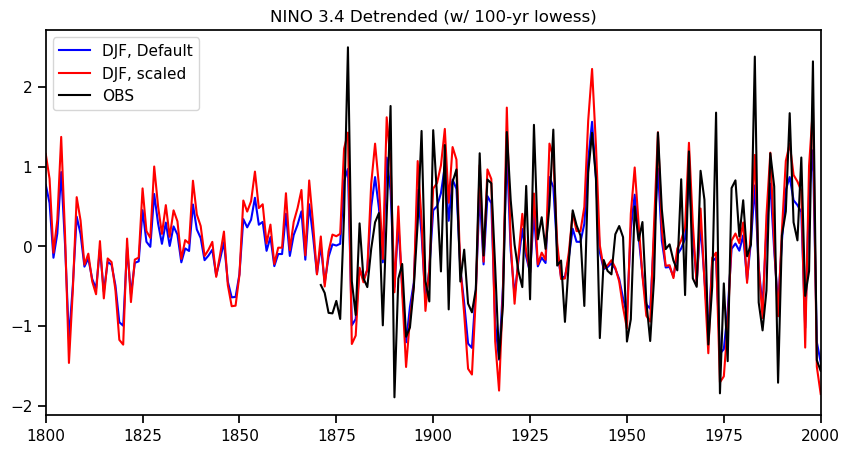

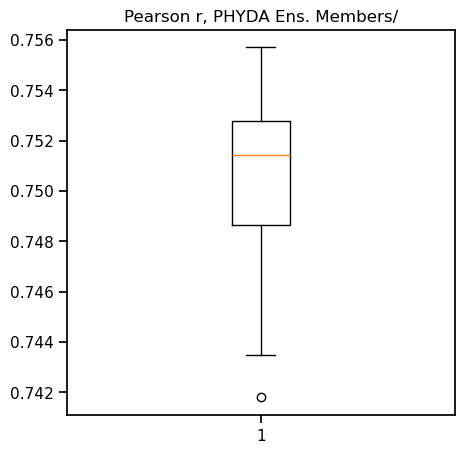

In [18]:
# Storage array of smoothed values
nino_djf_anom_lowess = np.zeros((100,yr_trim.size))*np.nan

# Lowess Smoothing of each ensemble member
for n_ens in np.arange(0,100):
    
    # Current ensemble member
    currens_nino = nino34_phyDJF[n_ens,:].copy()
    
    # Calculate the lowess smooth
    ninoDJF_smooth = statsmodels.nonparametric.smoothers_lowess.lowess(currens_nino,yr_trim,frac=frac_smooth)   # 30 year lowess
    
    # Remove lowess signal
    nino_djf_anom_lowess[n_ens,:] = currens_nino-ninoDJF_smooth[:,1]

# Figures for spot-checking
plt.figure(figsize=(10,5))
plt.title('NINO 3.4 (w/ '+str(yrs_smooth)+'-yr lowess)')
plt.plot(yr_trim,currens_nino,color='r',linestyle='-',label='DJF')
plt.plot(yr_trim,ninoDJF_smooth[:,1],color='r',linestyle='--')
plt.legend(loc=0)
plt.xlim(1800,2000)    

# DJF NINO 3.4 Detrended, including scaling to match observations----------------------------------------------------------------------------------------------

# Remove Mean and Standard Dev. of PHYDA
mean_nino_phyda              = np.expand_dims(np.mean(nino_djf_anom_lowess[:,i_base_phyda],axis=1),1)
stdv_nino_phyda              = np.expand_dims(np.std(nino_djf_anom_lowess[:,i_base_phyda],axis=1),1)
nino_djf_anom_lowess_rescale = (nino_djf_anom_lowess-mean_nino_phyda)/stdv_nino_phyda

# Apply Scaling from Observations
mean_obs_nino = np.mean(obs_ninoDJF[i_base_obs])
stdv_obs_nino = np.std(obs_ninoDJF[i_base_obs])
nino_djf_anom_lowess_rescale = (nino_djf_anom_lowess_rescale*stdv_obs_nino)+mean_obs_nino

# Figure for checking rescaling
n_ens = 10
plt.figure(figsize=(10,5))
plt.title('NINO 3.4 Detrended (w/ '+str(yrs_smooth)+'-yr lowess)')
plt.plot(yr_trim,nino_djf_anom_lowess[n_ens,:],color='b',linestyle='-',label='DJF, Default')
plt.plot(yr_trim,nino_djf_anom_lowess_rescale[n_ens,:],color='r',linestyle='-',label='DJF, scaled')
plt.plot(yrs_seas,obs_ninoDJF,color='k',linestyle='-',label='OBS')
plt.legend(loc=0)
plt.xlim(1800,2000)

# Check Scaling
print('Obs. Mean: ',mean_obs_nino,'; Obs. StDv:',stdv_obs_nino)
print('PHYDA Mean: ',np.mean(nino_djf_anom_lowess_rescale[20:25,i_base_phyda],axis=1))
print('PHYDA StDv: ',np.std(nino_djf_anom_lowess_rescale[20:25,i_base_phyda],axis=1))

# Calculate Correlations in Ensemble
correns_nino = np.zeros(100)*np.nan

# Ensemble loop for Correlation
for n_ens in np.arange(0,100):
    correns_nino[n_ens], pval = scipy.stats.pearsonr(obs_ninoDJF[i_base_obs],nino_djf_anom_lowess_rescale[n_ens,i_base_phyda])

# Histogram of correlations
plt.figure(figsize=(5,5))
plt.boxplot(correns_nino)
plt.title('Pearson r, PHYDA Ens. Members/')

# Save Ensemble AMO------------------------------------------------------------------------------------------------------------------------------

# Create Output Array
output_array = np.hstack(  (np.expand_dims(yr_trim,1),nino_djf_anom_lowess_rescale.swapaxes(0,1)) )
    
# Initialize and Create Dataframe
df_out_phyda_pdsi = pd.DataFrame(columns=cols_txt,data=output_array,index=None)

# Save to csv file
df_out_phyda_pdsi.to_csv('../data/ensphyda/indices/ensphyda_ninoDJF_scaled_detrend.csv',index=False)
#df_out_phyda_pdsi


## LOAD TAS ENSEMBLE DATA TO CALCULATE PDO

Text(0.5, 1.0, 'DJF PHYDA SST, w/ land-sea Masking')

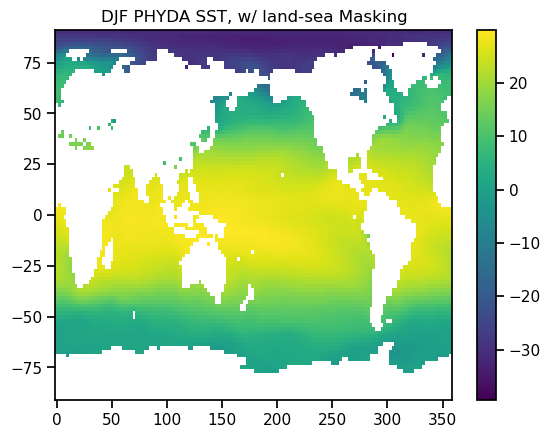

In [19]:
# For Trimming Seasonal SST Data
i_trim = np.where(yr_phyda>=800)[0]

# Load NINO 3.4 and AMO Indices
fname_phyda   = '../../../../GEODATA/PHYDA/v2/phyda_ens_tas_DecFeb_r.1-2000_d.21-Nov-2018.nc'
phyda_nc      = netCDF4.Dataset(fname_phyda,"r",format="NETCDF4")
tasDJF        = phyda_nc.variables['tas_ens'][:,i_trim,:,:] # get values
phyda_nc.close()

# Apply Land/Sea Mask
tasDJF = tasDJF*lsmask

# Figure to Check
plt.figure()
plt.pcolormesh(lon_phy,lat_phy,tasDJF[50,300,:,:])
plt.colorbar()
plt.title('DJF PHYDA SST, w/ land-sea Masking')


## PDO Index Calculation Using Principal Component Analysis approach
* Mantua et al method, with assist from Hannah Byrne
* https://drive.google.com/file/d/1RCYY-StjelFr_8XQIc0iX7h7YdyezTVu/view

Processing ENSEMBLE #0
Processing ENSEMBLE #1
Processing ENSEMBLE #2
Processing ENSEMBLE #3
Processing ENSEMBLE #4
Processing ENSEMBLE #5
Processing ENSEMBLE #6
Processing ENSEMBLE #7
Processing ENSEMBLE #8
Processing ENSEMBLE #9
Processing ENSEMBLE #10
Processing ENSEMBLE #11
Processing ENSEMBLE #12
Processing ENSEMBLE #13
Processing ENSEMBLE #14
Processing ENSEMBLE #15
Processing ENSEMBLE #16
Processing ENSEMBLE #17
Processing ENSEMBLE #18
Processing ENSEMBLE #19
Processing ENSEMBLE #20
Processing ENSEMBLE #21
Processing ENSEMBLE #22
Processing ENSEMBLE #23
Processing ENSEMBLE #24
Processing ENSEMBLE #25
Processing ENSEMBLE #26
Processing ENSEMBLE #27
Processing ENSEMBLE #28
Processing ENSEMBLE #29
Processing ENSEMBLE #30
Processing ENSEMBLE #31
Processing ENSEMBLE #32
Processing ENSEMBLE #33
Processing ENSEMBLE #34
Processing ENSEMBLE #35
Processing ENSEMBLE #36
Processing ENSEMBLE #37
Processing ENSEMBLE #38
Processing ENSEMBLE #39
Processing ENSEMBLE #40
Processing ENSEMBLE #41
Pr

Text(0.5, 1.0, 'EOF 1 (last ensemble member)')

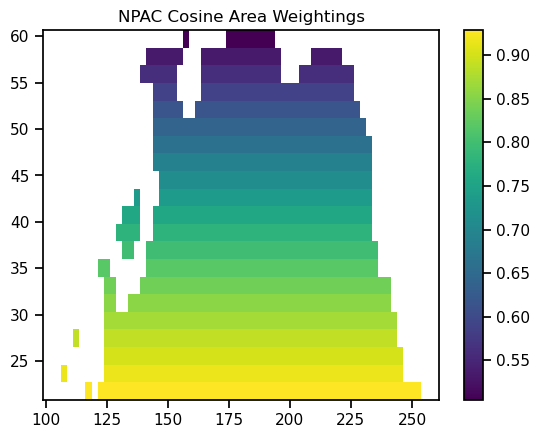

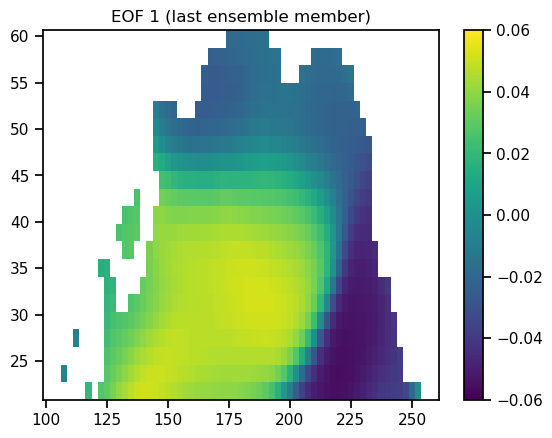

In [31]:
# Lat/lon Indices for North Pacific
i_lat = np.where( (lat_phy>=20) & (lat_phy<=60) )[0]
i_lon = np.where( (lon_phy>=100) & (lon_phy<=260) )[0]

# Lat/lon for North Pacific
lat_npac = lat_phy[i_lat].copy()
lon_npac = lon_phy[i_lon].copy()

# Trim Cosine Area Weighting Array
lat_wts_grid_npac = lat_wts_grid_ocean[i_lat,:][:,i_lon].copy()
plt.figure()
plt.pcolormesh(lon_npac,lat_npac,lat_wts_grid_npac)
plt.colorbar()
plt.title('NPAC Cosine Area Weightings')

# Storage Arrays
ensemb_fracvar1 = np.zeros((100))*np.nan
ensemb_pc1      = np.zeros((100,yr_trim.size))*np.nan
ensemb_eof1     = np.zeros((100,lat_npac.size,lon_npac.size))*np.nan

# Loop Through Each Ensemble Member
for n_ens in np.arange(0,100):
    print('Processing ENSEMBLE #'+str(n_ens))
    
    # Pull out current ensemble member----------------------------------------------------------------------------------
    currens_tas = tasDJF[n_ens,:,:,:].copy()
    
    # Trim North Pacific Region
    currens_tas_nopac = currens_tas[:,i_lat,:][:,:,i_lon].copy()
    #plt.figure()
    #plt.pcolor(lon_npac,lat_npac,currens_tas_nopac[300,:,:])
    #plt.colorbar()
    #plt.title('North Pacific')
    
    # Detrend and standardize
    currens_tas_nopac_detrend_zscore = np.zeros(currens_tas_nopac.shape)*np.nan
    for n_lat in enumerate(lat_npac):
        for n_lon in enumerate(lon_npac):
            
            # Current Grid cell
            curr_celltas = currens_tas_nopac[:,n_lat[0],n_lon[0]].copy()
            if np.sum(curr_celltas)>-1000:
                # Calculate the lowess smooth
                currcell_smooth = statsmodels.nonparametric.smoothers_lowess.lowess(curr_celltas,yr_trim,frac=frac_smooth)   # 30 year lowess
    
                # Remove lowess signal
                currcell_anom_lowess = curr_celltas-currcell_smooth[:,1]
            
                # Standardize to zero mean and unit standard deviation
                currcell_anom_lowess = (currcell_anom_lowess-np.mean(currcell_anom_lowess))/np.std(currcell_anom_lowess)
                currens_tas_nopac_detrend_zscore[:,n_lat[0],n_lon[0]] = currcell_anom_lowess.copy()
    
    # Apply Cosine Area Weighting
    currens_coswt_tas = currens_tas_nopac_detrend_zscore*lat_wts_grid_npac
    
    # Reformat for PCA-----------------------------------------------------------------------------------------------------
    # Initialize Matrices
    currtas_yr_cell = np.zeros((yr_trim.size,lat_npac.size*lon_npac.size))*np.nan
    lat_cell       = np.zeros((1,lat_npac.size*lon_npac.size))*np.nan
    
    # Initialize Gridcell Counter
    cnt_cell = np.array([0])
    
    # Reshape Matrix
    for n_lat in enumerate(lat_npac):
        for n_lon in enumerate(lon_npac):
        
            # Pull out current gridcell
            curr_cell = currens_coswt_tas[:,n_lat[0],n_lon[0]].copy()
            
            # Put in reformatted matrices (include latitude weighting)
            currtas_yr_cell[:,cnt_cell] = np.expand_dims(curr_cell,axis=1)
            
            # Store latitudefor current cell
            lat_cell[0,cnt_cell]   = copy.deepcopy(n_lat[1])
        
            # Iterate Cell Counter
            cnt_cell = cnt_cell+1;
    
    # Pull out first row/year to establish valid cells
    test_yr = copy.deepcopy(currtas_yr_cell[0,:]);
    i_land  = ~np.isnan(test_yr)
    
    # Final matrices for PCA
    pca_tas_npac    = currtas_yr_cell[:,i_land].copy()

    # Conduct the SVD-----------------------------------------------------------------------------------------------------
    u,s,v = np.linalg.svd(pca_tas_npac, full_matrices=0)

    # Fractional variance in each mode (from singular values)
    frac_var = (s*s)/np.sum(s*s) 
    var_pc1  = np.round(frac_var[0],decimals=3)*100
    
    # Pull out PCs 1 and  associated EOF
    pc1  = u[:,0].copy();   
    eof1 = v[0,:].copy() 
    
    # Put legit values into the new EOF arrays and reshape
    eof1_map = np.zeros((lat_npac.size*lon_npac.size))*np.nan; 
    eof1_map[i_land] = eof1.copy(); 
    eof1_map         = eof1_map.reshape((lat_npac.size,lon_npac.size))
    
    # Save Results-----------------------------------------------------------------------------------------------------------
    ensemb_fracvar1[n_ens] = copy.deepcopy(var_pc1)
    ensemb_pc1[n_ens,:] = copy.deepcopy(pc1)
    ensemb_eof1[n_ens,:,:] = copy.deepcopy(eof1_map)

plt.figure()
plt.pcolormesh(lon_npac,lat_npac,eof1_map,vmin=-0.06,vmax=0.06)
plt.colorbar()
plt.title('EOF 1 (last ensemble member)')
    

## PDO Processing

Obs. Mean:  0.17108169934640524 ; Obs. StDv: 1.070436709945992
PHYDA Mean:  [0.1710817 0.1710817 0.1710817 0.1710817 0.1710817]
PHYDA StDv:  [1.07043671 1.07043671 1.07043671 1.07043671 1.07043671]


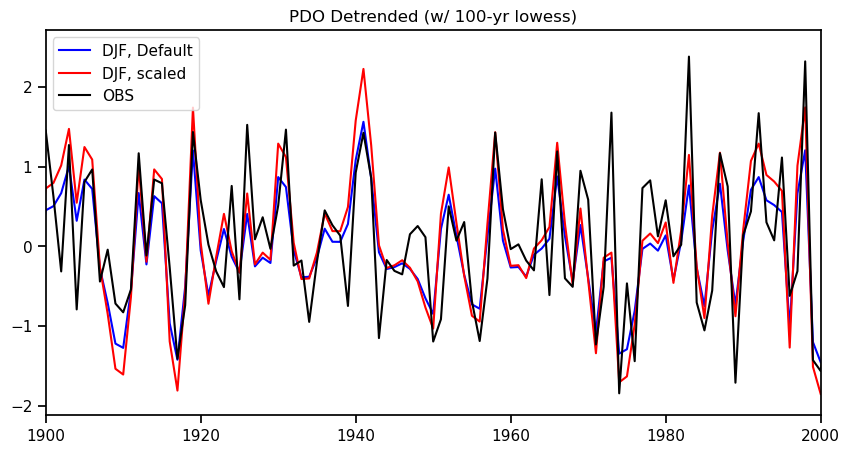

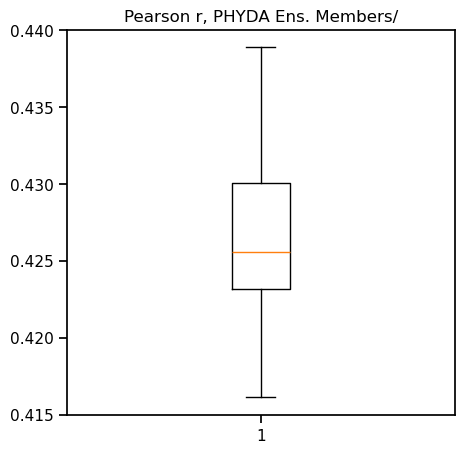

In [32]:
# Invert to Match Observations
pdo_djf_anom_lowess = ensemb_pc1*-1;

# Remove Mean and Standard Dev. of PHYDA PDO
mean_pdo_phyda              = np.expand_dims(np.mean(pdo_djf_anom_lowess[:,i_base_phyda],axis=1),1)
stdv_pdo_phyda              = np.expand_dims(np.std(pdo_djf_anom_lowess[:,i_base_phyda],axis=1),1)
pdo_djf_anom_lowess_rescale = (pdo_djf_anom_lowess-mean_pdo_phyda)/stdv_pdo_phyda

# Apply Scaling from Observations
mean_obs_pdo = np.mean(obs_pdoDJF[i_base_obs])
stdv_obs_pdo = np.std(obs_pdoDJF[i_base_obs])
pdo_djf_anom_lowess_rescale = (pdo_djf_anom_lowess_rescale*stdv_obs_pdo)+mean_obs_pdo

# Figure for checking rescaling
n_ens = 10
plt.figure(figsize=(10,5))
plt.title('PDO Detrended (w/ '+str(yrs_smooth)+'-yr lowess)')
plt.plot(yr_trim,nino_djf_anom_lowess[n_ens,:],color='b',linestyle='-',label='DJF, Default')
plt.plot(yr_trim,nino_djf_anom_lowess_rescale[n_ens,:],color='r',linestyle='-',label='DJF, scaled')
plt.plot(yrs_seas,obs_ninoDJF,color='k',linestyle='-',label='OBS')
plt.legend(loc=0)
plt.xlim(1900,2000)

# Check Scaling
print('Obs. Mean: ',mean_obs_pdo,'; Obs. StDv:',stdv_obs_pdo)
print('PHYDA Mean: ',np.mean(pdo_djf_anom_lowess_rescale[20:25,i_base_phyda],axis=1))
print('PHYDA StDv: ',np.std(pdo_djf_anom_lowess_rescale[20:25,i_base_phyda],axis=1))

# Calculate Correlations in Ensemble
correns_pdo = np.zeros(100)*np.nan

# Ensemble loop for Correlation
for n_ens in np.arange(0,100):
    correns_pdo[n_ens], pval = scipy.stats.pearsonr(obs_pdoDJF[i_base_obs],pdo_djf_anom_lowess_rescale[n_ens,i_base_phyda])

# Histogram of correlations
plt.figure(figsize=(5,5))
plt.boxplot(correns_pdo)
plt.title('Pearson r, PHYDA Ens. Members/')

# Save Ensemble AMO------------------------------------------------------------------------------------------------------------------------------

# Create Output Array
output_array = np.hstack(  (np.expand_dims(yr_trim,1),pdo_djf_anom_lowess_rescale.swapaxes(0,1)) )
    
# Initialize and Create Dataframe
df_out_phyda_pdsi = pd.DataFrame(columns=cols_txt,data=output_array,index=None)

# Save to csv file
df_out_phyda_pdsi.to_csv('../data/ensphyda/indices/ensphyda_pdoDJF_scaled_detrend.csv',index=False)
#df_out_phyda_pdsi
